## Импорт библиотек

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, models, transforms

import numpy as np

import PIL
import pickle
from skimage import io
from PIL import Image
from pathlib import Path
import os
import copy

from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

from tqdm.notebook import tqdm

## Подготовка изображений

In [2]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])

        if self.mode == 'test':
            x = self._prepare_sample(x)
            x = transform(x)    
            return x
        else:
            # добавляем аугментацию для train изображений
            transform_test = transforms.Compose([ 
                transforms.RandomRotation(degrees=30),
                transforms.RandomHorizontalFlip(),
                transforms.RandomPerspective(distortion_scale=0.2, p=0.4),
                transforms.RandomApply([transforms.CenterCrop(size=(220, 220))], p=0.5),
                transforms.RandomApply([transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))], p=0.4),
                transforms.Resize([244, 244]),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            x = transform_test(x) 
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [3]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TRAIN_DIR = Path('../input/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('../input/journey-springfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [4]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [5]:
val_dataset = SimpsonsDataset(val_files, mode='val')
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [6]:
n_classes = len(np.unique(train_val_labels))

## Визуализация датасета

In [7]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]


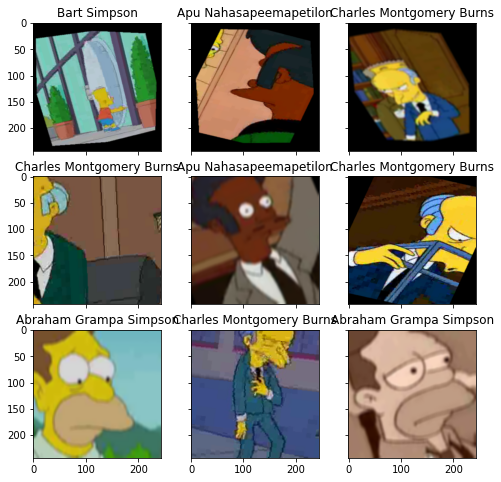

In [8]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

## Обучение модели

In [9]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [10]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [11]:
def train(train_files, val_files, model, epochs, batch_size, optimizer, criterion, scheduler, deacrease_epochs=5):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    # init variables to store best model weights, best accuracy, best epoch number, epochs since best accuracy acheived
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    epochs_since_best = 0

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        # opt = torch.optim.Adam(model.parameters())
        # criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            scheduler.step()
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

            # сохранение лучшей модели
            if val_acc > best_acc:
                best_acc = val_acc
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
            else:
                epochs_since_best += 1
            
            # Остановка обучение, если модель не обучается в течение deacrease_epochs эпох
            if epochs_since_best > deacrease_epochs:
                print(f'Stopping training. The validation accuracy has been decreasing for {deacrease_epochs} epochs.')
                break
    model.load_state_dict(best_model_wts)
    return history

In [12]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

## Новые модели

In [13]:
res_mod = models.resnet50(pretrained=True)
# обучаем только последний свёрточный слой
for name, child in res_mod.named_children():
    if name in ['layer4']:
        print(name + ' has been unfrozen')
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

layer4 has been unfrozen


In [14]:
res_mod.fc = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Linear(1024, n_classes)
)

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(list(list(res_mod.fc.parameters()) + list(res_mod.layer4.parameters())), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
res_mod.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:
history = train(train_dataset, val_dataset, model=res_mod, criterion=criterion,
                             epochs=25, batch_size=64, optimizer=optimizer, scheduler=scheduler, deacrease_epochs=5)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.2529852938914771

Epoch 001 train_loss: 0.2530     val_loss 0.2548 train_acc 0.9325 val_acc 0.9326


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.23082584664923225

Epoch 002 train_loss: 0.2308     val_loss 0.2976 train_acc 0.9368 val_acc 0.9230


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.20520396604130253

Epoch 003 train_loss: 0.2052     val_loss 0.2622 train_acc 0.9473 val_acc 0.9333


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.18725573188341174

Epoch 004 train_loss: 0.1873     val_loss 0.2615 train_acc 0.9496 val_acc 0.9337


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.18097501242568564

Epoch 005 train_loss: 0.1810     val_loss 0.2563 train_acc 0.9510 val_acc 0.9356


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.1637168436819174

Epoch 006 train_loss: 0.1637     val_loss 0.2400 train_acc 0.9557 val_acc 0.9379


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.1535053191341935

Epoch 007 train_loss: 0.1535     val_loss 0.2437 train_acc 0.9583 val_acc 0.9391


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.09479537881192747

Epoch 008 train_loss: 0.0948     val_loss 0.1982 train_acc 0.9753 val_acc 0.9522


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.08116362248583266

Epoch 009 train_loss: 0.0812     val_loss 0.2003 train_acc 0.9794 val_acc 0.9530


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.07477645397775541

Epoch 010 train_loss: 0.0748     val_loss 0.1908 train_acc 0.9806 val_acc 0.9561


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.07061829725721179

Epoch 011 train_loss: 0.0706     val_loss 0.1897 train_acc 0.9812 val_acc 0.9557


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.06826270337632594

Epoch 012 train_loss: 0.0683     val_loss 0.1828 train_acc 0.9820 val_acc 0.9591


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.06336214500919285

Epoch 013 train_loss: 0.0634     val_loss 0.1708 train_acc 0.9819 val_acc 0.9587


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.06307986919630583

Epoch 014 train_loss: 0.0631     val_loss 0.1664 train_acc 0.9832 val_acc 0.9610


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.05621152043143737

Epoch 015 train_loss: 0.0562     val_loss 0.1740 train_acc 0.9855 val_acc 0.9559


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.058467793315762635

Epoch 016 train_loss: 0.0585     val_loss 0.1796 train_acc 0.9846 val_acc 0.9599


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.059362273254215905

Epoch 017 train_loss: 0.0594     val_loss 0.1936 train_acc 0.9850 val_acc 0.9534
Stopping training. The validation accuracy has been decreasing for 5 epochs.


### resnet

In [ ]:
res_mod = models.resnet50(pretrained=True)
res_mod.fc = nn.Linear(2048, n_classes)

# обучаем только последний свёрточный слой
for name, child in res_mod.named_children():
    if name in ['layer4']:
        print(name + ' has been unfrozen')
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(res_mod.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
res_mod.to(DEVICE)

In [ ]:
history = train(train_dataset, val_dataset, model=res_mod, criterion=criterion,
                             epochs=25, batch_size=64, optimizer=optimizer, scheduler=scheduler, deacrease_epochs=5)

In [ ]:
# save the weights of our net
model_weights = copy.deepcopy(res_mod.state_dict())
torch.save(model_weights, "res_mod.pth")

In [ ]:
# загружаем сохраненное состояние весов нейросети
res_mod.load_state_dict(torch.load("./res_mod.pth"))

## Ну и что теперь со всем этим делать?

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [29]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
res_mod.to('cuda')

In [30]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(res_mod, ex_img.unsqueeze(0))

In [31]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(res_mod, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [32]:
f1_score(actual_labels, y_pred, average="macro")

0.9365079365079365

## Submit на Kaggle

In [33]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(res_mod, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
! ls 

In [34]:
import pandas as pd
#my_submit = pd.read_csv("../input/journey-springfield/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [35]:
my_submit.to_csv('res_mod2_baseline.csv', index=False)